## **Segmentation of optical vessels**
### **Introduction** 
The objective of this project is to segment the optical vessels in diabetic retinopathy data set.

We start by viewing a few sample input images:
 

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please s

Text(0.5, 1.0, 'Input image')

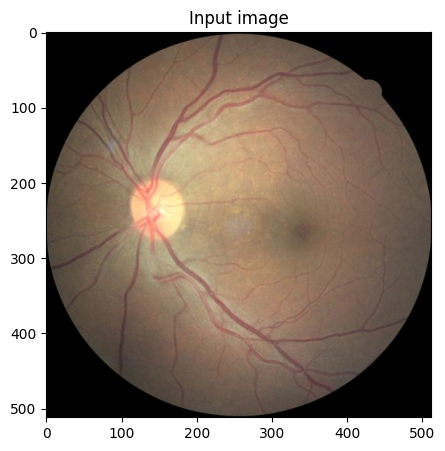

In [1]:
# Imports
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
from skimage.filters.ridges import sato, frangi
import numpy as np
from dataloader import OpticalDataloader, vessel_mask_ridge, zscore_norm
import logging
import random
import torch

logging.basicConfig(level=logging.INFO)
cols = 2
plt.rcParams["figure.figsize"] = (5 * cols, 5)

# Read input images
DATA_DIR = "data/diabetic-retinopathy-dataset/resized/train/"
image_files = glob(DATA_DIR + "*")

# display a sample image
image_path = image_files[0]  
plt.imshow(Image.open(image_path))
plt.title('Input image')

### **Vessel segmentation**:
We can do this in 2 steps:
1) Use computer-vision based techniques to do unsupervised noisy segmentation of vessels
2) Use noisy vessel labels to train a 2D UNet and de-noise the vessel labels

#### **Unsupervised CV-based vessel detection(Ridge Filter)**
We can use Hessian-based vessel/tube detection filters to detect contours of vessels. Some examples of such filters are sato and frangi filters. These filters detect vessels by computing the Hessian(2nd derivative) matrix, and using the ratio of largest/smallest eigenvalues as a measure of vesselness.

Text(0.5, 1.0, 'Vessel mask (sato)')

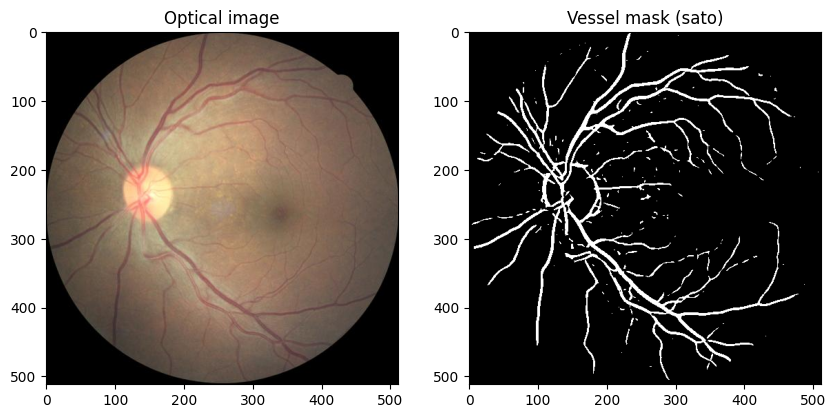

In [2]:
img_rgb_np = Image.open(image_path)
img_np = np.array(Image.open(image_path).convert('L'))

# normalize the image and detect vessels using sato filter
img_np = zscore_norm(img_np)
vessel_mask_np = vessel_mask_ridge(img_np=img_np)

# display image and mask
plt.subplot(1, 2, 1)
plt.imshow(img_rgb_np)
plt.title('Optical image')

plt.subplot(1, 2, 2)
plt.imshow(vessel_mask_np, cmap='gray')
plt.title('Vessel mask (sato)')


**************************************
len(train_set) = 0
Done Loading
**************************************


Text(0.5, 1.0, 'Vessel mask (sato)')

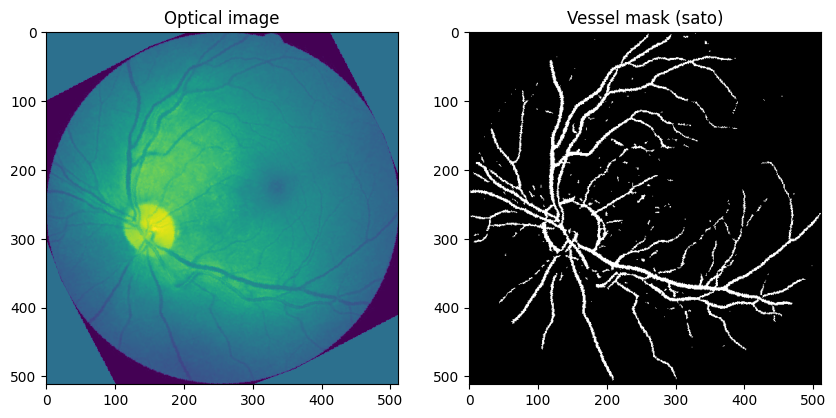

In [4]:
from dataloader import vessel_mask_ridge, OpticalDataloader

val_data = OpticalDataloader(paths_list = [], mode="valid")

img_np = torch.unsqueeze(torch.Tensor(img_np), 0)
vessel_mask_np = torch.Tensor(vessel_mask_np)

img_np, vessel_mask_np = val_data.augment(img_np, vessel_mask_np)

# display image and mask
plt.subplot(1, 2, 1)
plt.imshow(torch.squeeze(img_np))
plt.title('Optical image')

plt.subplot(1, 2, 2)
plt.imshow(vessel_mask_np, cmap='gray')
plt.title('Vessel mask (sato)')

These vessel annotations are not perfect but they can be a good start.

### **Generating annotated data and model training**
Let us now train a 2D UNet model to segment these vessels using the noisy annotations we just created

In [4]:
data_dir = "data/diabetic-retinopathy-dataset/resized"
n_dev = 500
n_test = 200
n_train = int(n_dev * 0.7)
dev_paths_list = glob(data_dir + "/train/*t.jpeg")[:n_dev]
test_paths_list = glob(data_dir + "/test/*t.jpeg")[:n_test]
random.Random(4).shuffle(dev_paths_list)
random.Random(4).shuffle(test_paths_list)

logging.info(f"{len(dev_paths_list)} Training images found")

train_paths_list, val_paths_list = dev_paths_list[:n_train], dev_paths_list[n_train:]
data = OpticalDataloader(train_paths_list, val_paths_list, test_paths_list)

INFO:root:500 Training images found
  0%|          | 0/350 [00:00<?, ?it/s]


UnboundLocalError: local variable 'vessel_mask' referenced before assignment

In [ ]:
model = UNetModel("output", False, False)
model.define_model()
model.initialize_weights(global_step=0)

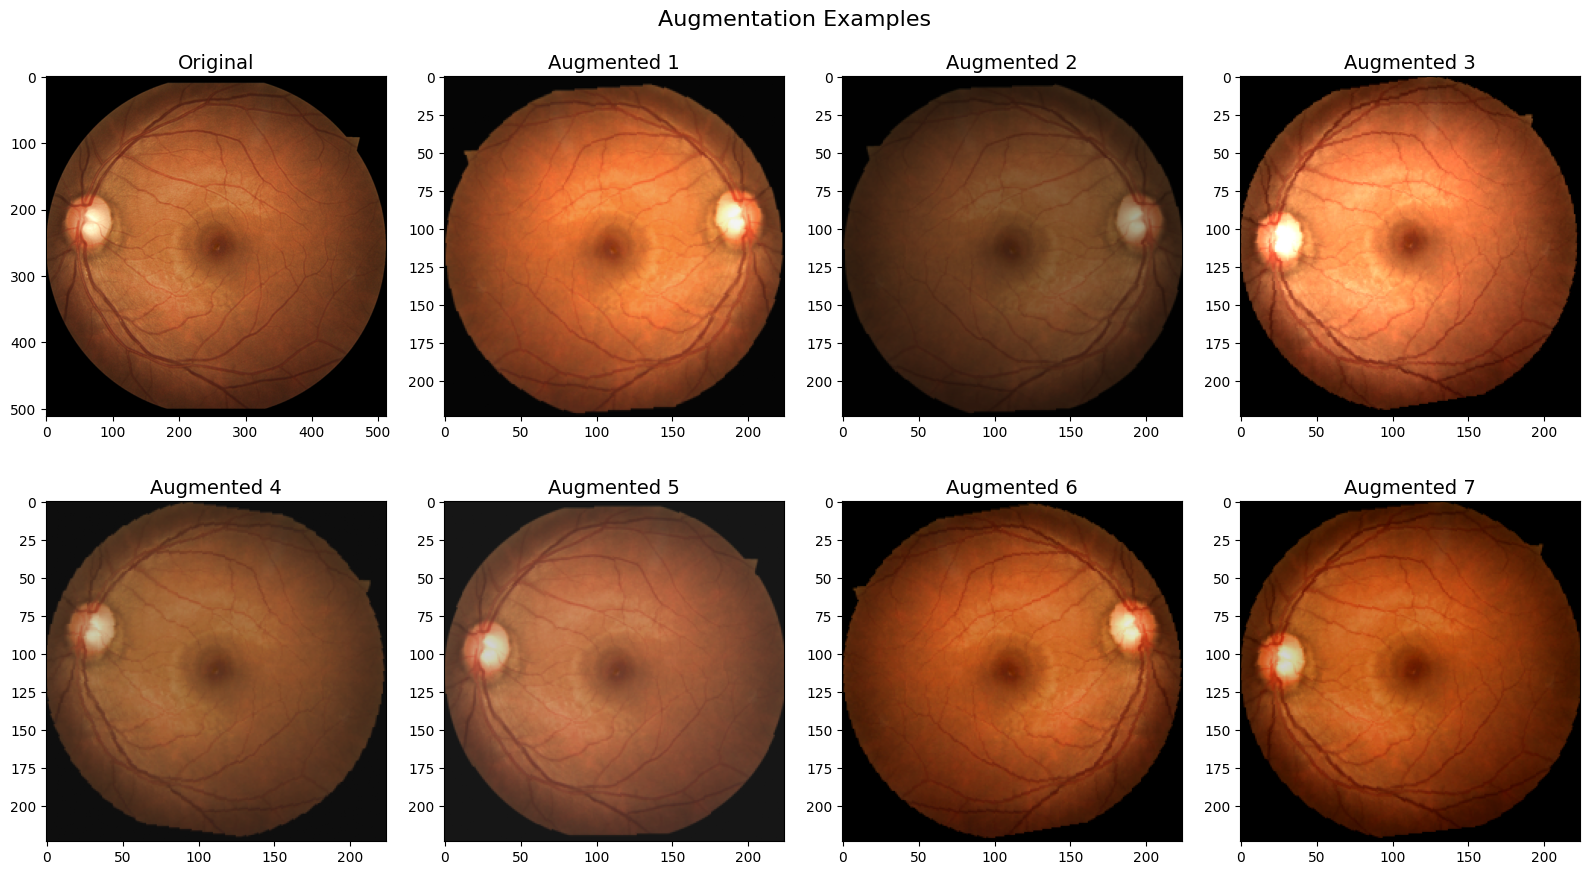

In [13]:
from PIL import Image
import matplotlib.pyplot as plt
from src.utils import crop_and_pad_image
from torchvision import transforms as T

# Load the source image
image_path = image_files[2]  # Assuming image_files is defined elsewhere
src_image = Image.open(image_path)

# Crop and pad the image
cropped_image = crop_and_pad_image(image_path)

# Define the transformation
transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomAffine(degrees=10, translate=(0.01, 0.01), scale=(0.99, 1.01)),
    T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.01),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
])

# Apply the transformation multiple times and show the results
num_augmentations = 7
fig, axes = plt.subplots(2, 4, figsize=(16, 9))

# Flatten the axes array
axes = axes.flatten()

# Set title for the entire figure
fig.suptitle("Augmentation Examples", fontsize=16)

# Original cropped image
axes[0].imshow(cropped_image)
axes[0].set_title("Original", fontsize=14)

# Apply augmentation and display
for i in range(1, num_augmentations + 1):
    augmented_image = transform(cropped_image).permute(1, 2, 0)
    axes[i].imshow(augmented_image)
    axes[i].set_title(f"Augmented {i}", fontsize=14)

# Hide remaining axes
for ax in axes[num_augmentations + 1:]:
    ax.axis('off')

# Adjust layout and display
plt.tight_layout()
plt.show()

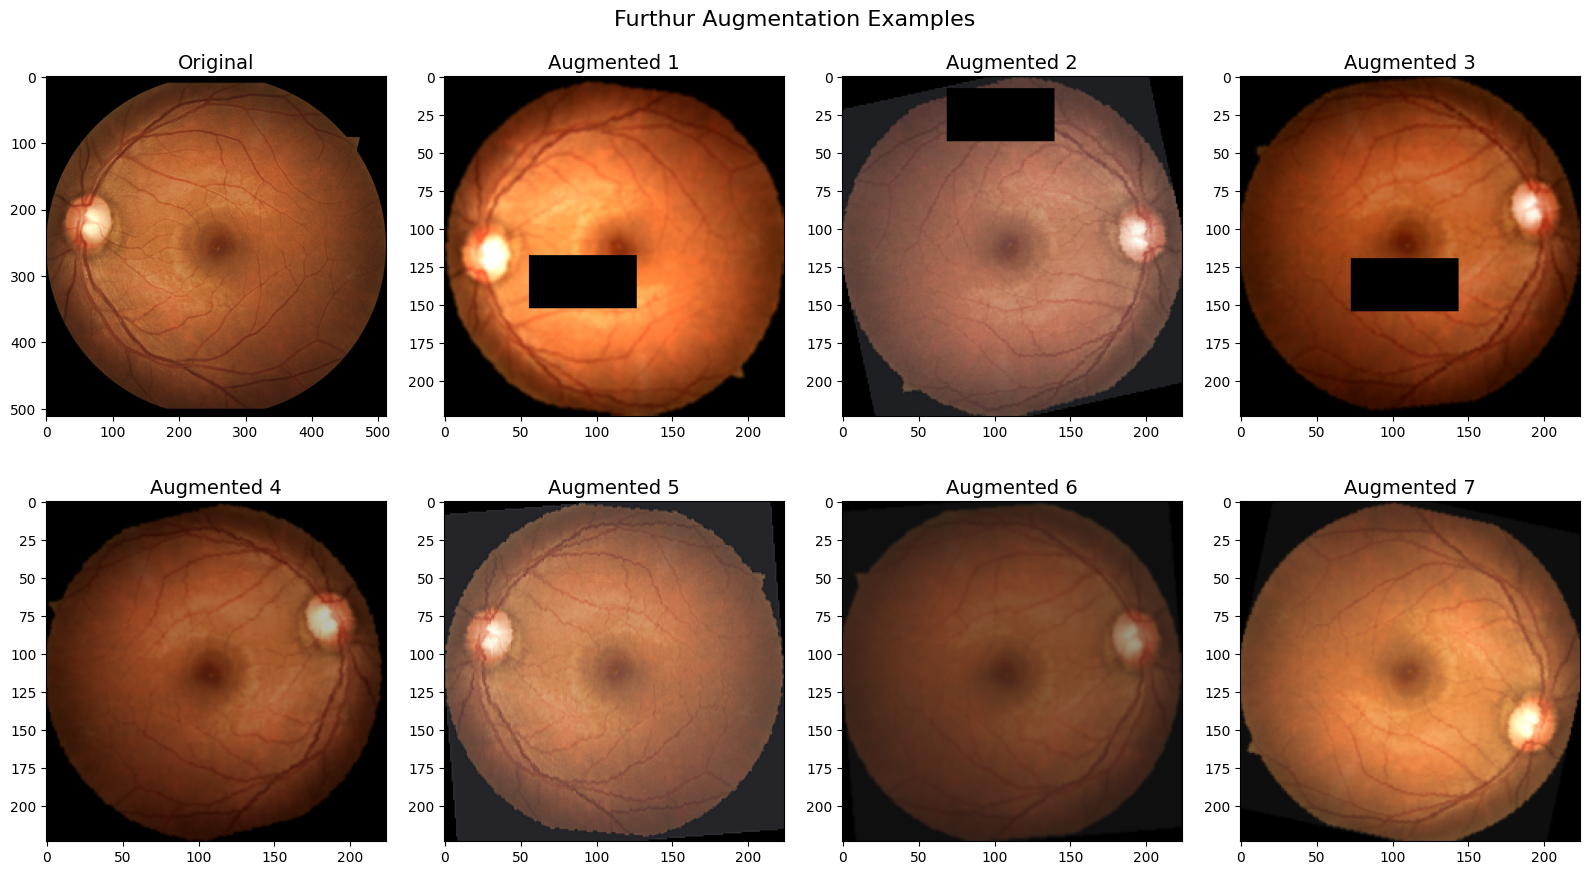

In [32]:
from PIL import Image
import matplotlib.pyplot as plt
from src.utils import crop_and_pad_image
from torchvision import transforms as T

# Load the source image
image_path = image_files[2]  # Assuming image_files is defined elsewhere
src_image = Image.open(image_path)

# Crop and pad the image
cropped_image = crop_and_pad_image(image_path)

# Define the transformation
transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomAffine(degrees=10, translate=(0.01, 0.01), scale=(0.99, 1.01)),
    T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.01),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.RandomVerticalFlip(p=0.5),
    T.GaussianBlur(kernel_size=3),  # You can adjust kernel size as needed
    T.RandomResizedCrop(size=(224, 224), scale=(0.99, 1.0), ratio=(0.75, 1.333)),
    T.RandomAdjustSharpness(sharpness_factor=2),
    T.RandomAutocontrast(),
    T.ToTensor(),
    T.RandomErasing(p=0.2, scale=(0.05, 0.05), ratio=(0.5, 0.5)),
])

# Apply the transformation multiple times and show the results
num_augmentations = 8
fig, axes = plt.subplots(2, num_augmentations // 2, figsize=(16, 9))

# Flatten the axes array
axes = axes.flatten()

# Set title for the entire figure
fig.suptitle("Furthur Augmentation Examples", fontsize=16)

# Original cropped image
axes[0].imshow(cropped_image)
axes[0].set_title("Original", fontsize=14)

# Apply augmentation and display
for i in range(1, num_augmentations):
    augmented_image = transform(cropped_image).permute(1, 2, 0)
    axes[i].imshow(augmented_image)
    axes[i].set_title(f"Augmented {i}", fontsize=14)

# Hide remaining axes
for ax in axes[num_augmentations:]:
    ax.axis('off')

# Adjust layout and display
plt.tight_layout()
plt.show()